In [175]:
# Importing the libraries
import itertools
import numpy as np # for array operations
import pandas as pd # for working with DataFrames
import geopandas as gpd
import requests, io # for HTTP requests and I/O commands
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

In [ ]:
# Importing the data
dataset = gpd.read_file(r'C:\Users\mieke\Documents\Msc Thesis\Datasets\Yield Data\Karnataka\rf_geodataframe1.geojson') 
dataset.head()

In [176]:
#dataset['Previous Average Yield(Kg/Ha)'] = dataset['Previous Average Yield(Kg/Ha)'].fillna(dataset['Average Yield(Kg/Ha)'])
dataset_copy = dataset.copy()
dataset_copy.loc[(dataset_copy['Season'] == 'Summer'), 'Season'] = 0
dataset_copy.loc[(dataset_copy['Season'] == 'Kharif'), 'Season'] = 1
dataset_copy.loc[(dataset_copy['Season'] == 'Rabi'), 'Season'] = 2


dataset_copy.loc[(dataset_copy['IRR_RF'] == 'irr'), 'IRR_RF'] = 0
dataset_copy.loc[(dataset_copy['IRR_RF'] == 'rf'), 'IRR_RF'] = 1

sqm_to_sqkm = 10**6
dataset_copy['Area'] = dataset_copy.to_crs(epsg = 3857).geometry.area / sqm_to_sqkm # Calculate the area size

In [65]:
dataset_subset = dataset_copy[dataset_copy['Crop'] == 'paddy'].reset_index()
yields = dataset_subset['Average Yield(Kg/Ha)']

# Datapoints are considered as outliers when then are outside of the tw0-sided 95% confidence interval
fifth_perc = np.percentile(dataset_subset['Average Yield(Kg/Ha)'], 2.5)
nintyfifth_perc = np.percentile(dataset_subset['Average Yield(Kg/Ha)'], 97.5)
dataset_subset['outlier_tf'] = (dataset_subset['Average Yield(Kg/Ha)'] < fifth_perc) | (dataset_subset['Average Yield(Kg/Ha)'] > nintyfifth_perc)
datasubset_wo = dataset_subset[dataset_subset['outlier_tf'] == False] 
outliers = dataset_subset[dataset_subset['outlier_tf'] == True] # So 448 datapoints are outliers

In [208]:
len(outliers[outliers['Year'] == 2018]) # 221, 142, 85
len(dataset_subset[dataset_subset['Year'] == 2018]) # 3028, 2993, 2918

2918

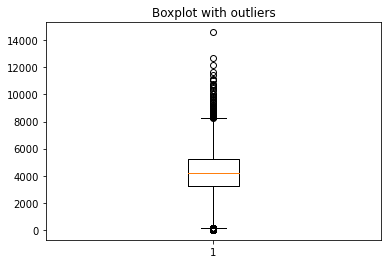

In [178]:
# Creating plot
plt.boxplot(dataset_subset['Average Yield(Kg/Ha)'])
plt.title('Boxplot with outliers') 
# show plot
plt.show()

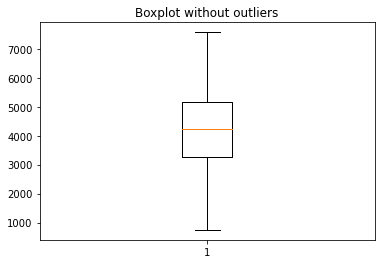

In [179]:
# Creating plot
plt.boxplot(datasubset_wo['Average Yield(Kg/Ha)'])
plt.title('Boxplot without outliers') 
# show plot
plt.show()

In [ ]:
datasubset_wo.head()

In [ ]:
# DECIDE ON HOW TO DEAL WITH NAN VALUES
#datasubset_wo = datasubset_wo.drop(['Previous Average Yield(Kg/Ha)', 'LAI_between', 'NDVI_between', 'SSM_between', 'LST_between', 'max_LST_between'], axis = 1)
#datasubset_wo.head(20)
datasubset_wo[datasubset_wo['SSM_harvest'].isna() == True]
#datasubset_wo = datasubset_wo.dropna(axis=0) # drop data with missing values in certain columns (RandomForestRegressor can not handle them)

In [ ]:
dataset_subset.iloc[18,:]

In [ ]:
outliers

In [95]:
cols = outliers.columns
outliers_df = gpd.GeoDataFrame(columns=cols, geometry = 'geometry')

In [ ]:
#outliers_df = 
#cols = outliers.columns[0]
outliers_df = pd.DataFrame(columns=cols)
#outliers_df = pd.concat(pd.Series(outliers_df), outliers.loc[i,:])
#outliers_df.append(outliers.iloc[i,:])
#outliers_df = outliers_df.join(outliers.loc[i,:], how='inner')
outliers_df = pd.concat([outliers_df, outliers.loc[i,:].to_frame().T], ignore_index=True)
outliers_df

In [162]:
outliers_df = pd.DataFrame()
for i in outliers.index:
    df_temp = dataset_subset[(dataset_subset['Insurance Unit'] == outliers.loc[i,'Insurance Unit']) & (dataset_subset['District'] == outliers.loc[i,'District']) & (dataset_subset['Gram Panchayat/Hobli'] == outliers.loc[i,'Gram Panchayat/Hobli'])]
    outliers_df = pd.concat([outliers_df, df_temp], ignore_index=True)


In [180]:
#outliers = outliers.drop(['Previous Average Yield(Kg/Ha)', 'LAI_between', 'NDVI_between', 'SSM_between', 'LST_between', 'max_LST_between'], axis = 1)
comp = outliers.iloc[:,[4,-2]] # Show this for addagadde

Text(147.0879960473363, 0.5, 'latitude')

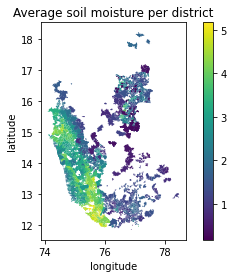

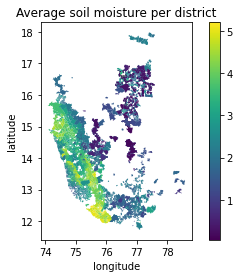

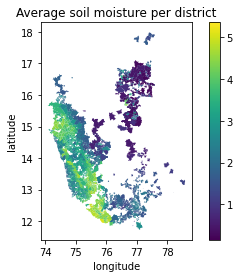

In [200]:
paddy_2016 = dataset_copy[(dataset_copy['Crop'] == 'paddy') & (dataset_copy['Year'] == 2016)]
paddy_2016.plot(column = 'LAI_harvest', legend = True)
plt.title('Average soil moisture per district')
plt.xlabel('longitude')
plt.ylabel('latitude')

paddy_2017 = dataset_copy[(dataset_copy['Crop'] == 'paddy') & (dataset_copy['Year'] == 2017)]
paddy_2017.plot(column = 'LAI_harvest', legend = True)
plt.title('Average soil moisture per district')
plt.xlabel('longitude')
plt.ylabel('latitude')

paddy_2018 = dataset_copy[(dataset_copy['Crop'] == 'paddy') & (dataset_copy['Year'] == 2018)]
paddy_2018.plot(column = 'LAI_harvest', legend = True)
plt.title('Average soil moisture per district')
plt.xlabel('longitude')
plt.ylabel('latitude')


In [214]:
outliers_trial = pd.DataFrame(outliers_df)
outliers_trial

,index,Year,Season,Insurance Unit,Gram Panchayat/Hobli,District,Taluk,Crop,IRR_RF,Average Yield(Kg/Ha),...,NDVI_harvest,SSM_sow,SSM_harvest,LST_sow,LST_harvest,max_LST_sow,max_LST_harvest,geometry,Area,outlier_tf
0,52,2016,1,abbana,gp,hassan,alur,paddy,0,12708.360,...,0.717371,17.294672,14.257984,25.241667,26.691530,25.937500,27.763393,"POLYGON ((75.92126 12.91813, 75.92132 12.91799...",15.363604,True
1,53,2017,1,abbana,gp,hassan,alur,paddy,0,7065.950,...,0.867178,12.075627,23.205267,24.730469,24.830390,26.000000,25.715279,"POLYGON ((75.92126 12.91813, 75.92132 12.91799...",15.363604,False
2,54,2018,1,abbana,gp,hassan,alur,paddy,0,6460.078,...,0.767756,19.095657,18.829685,NaN,26.476177,NaN,27.145834,"POLYGON ((75.92126 12.91813, 75.92132 12.91799...",15.363604,False
3,217,2016,1,addagadde,gp,chikkamagaluru,sringeri,paddy,1,4042.390,...,0.729552,22.316547,21.256630,25.893519,26.783725,27.937500,27.462053,"POLYGON ((75.28328 13.47824, 75.28323 13.47835...",24.430099,False
4,218,2017,1,addagadde,gp,chikkamagaluru,sringeri,paddy,1,7645.040,...,0.831271,22.290237,23.357777,26.565104,26.900908,27.937500,27.206249,"POLYGON ((75.28328 13.47824, 75.28323 13.47835...",24.430099,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,47360,2018,1,shigganva,h,haveri,shiggaon,paddy,1,336.598,...,0.654768,16.741959,12.532734,33.981181,33.518723,38.562500,37.790180,"POLYGON ((75.33433 15.08154, 75.33432 15.08159...",190.118700,True
1615,47993,2016,1,tambrahalli,h,ballari,hagaribommannahalli,paddy,0,4934.590,...,0.402330,11.505961,10.243452,36.784973,38.356226,39.812500,44.575520,"POLYGON ((76.90085 15.22220, 76.90085 15.22218...",357.322413,False
1616,47994,2017,1,tambrahalli,h,ballari,hagaribommannahalli,paddy,0,7795.150,...,0.591238,4.898227,12.387896,40.036520,34.327563,45.750000,37.605770,"POLYGON ((76.90085 15.22220, 76.90085 15.22218...",357.322413,True
1617,47995,2018,1,tambrahalli,h,ballari,hagaribommannahalli,paddy,0,6093.462,...,0.395536,3.074512,5.638225,39.696269,38.023460,44.270832,43.855770,"POLYGON ((76.90085 15.22220, 76.90085 15.22218...",357.322413,False


In [220]:
outliers_mail.loc[(outliers_mail['Season'] == 0), 'Season'] = 'Summer'

In [230]:
outliers_sort = outliers.sort_values('Average Yield(Kg/Ha)')
outliers_mail = pd.DataFrame()
for i in outliers_sort.index:
    df_temp = dataset_subset[(dataset_subset['Insurance Unit'] == outliers_sort.loc[i,'Insurance Unit']) & (dataset_subset['District'] == outliers_sort.loc[i,'District']) & (dataset_subset['Gram Panchayat/Hobli'] == outliers_sort.loc[i,'Gram Panchayat/Hobli'])]
    outliers_mail = pd.concat([outliers_mail, df_temp], ignore_index=True)
outliers_mail.loc[(outliers_mail['Season'] == 0), 'Season'] = 'Summer'
outliers_mail.loc[(outliers_mail['Season'] == 1), 'Season'] = 'Kharif'
outliers_mail.loc[(outliers_mail['Season'] == 2), 'Season'] = 'Rabi'
outliers_mail = pd.DataFrame(outliers_mail)
outliers_mail = outliers_mail[['Year', 'Season', 'Insurance Unit', 'Gram Panchayat/Hobli', 'District', 'Taluk', 'Crop', 'Average Yield(Kg/Ha)', 'outlier_tf']]
outliers_mail = outliers_mail.loc[[18,19,20,1469,1470,1471,65,66,67,1616,1617,1618],:]
# 18,19,20,1469,1470,1471,1609,1610,1611,1616,1617,1618


In [233]:
check = outliers_mail[(outliers_mail['Year'] == 2017) & (outliers_mail['outlier_tf'] == True)]

In [181]:
comp_df = pd.DataFrame(comp)

In [194]:
#outliers_df = outliers_df.drop(['Previous Average Yield(Kg/Ha)', 'LAI_between', 'NDVI_between', 'SSM_between', 'LST_between', 'max_LST_between'], axis = 1)
outliers_df.iloc[:,[3,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]].head(20) # Show this for addagadde

,Insurance Unit,IRR_RF,Average Yield(Kg/Ha),LAI_sow,LAI_harvest,NDVI_sow,NDVI_harvest,SSM_sow,SSM_harvest,LST_sow,LST_harvest,max_LST_sow,max_LST_harvest,geometry,Area,outlier_tf
0,abbana,0,12708.360,2.546240,3.394249,0.694239,0.717371,17.294672,14.257984,25.241667,26.691530,25.937500,27.763393,"POLYGON ((75.92126 12.91813, 75.92132 12.91799...",15.363604,True
1,abbana,0,7065.950,2.628837,3.665855,0.921089,0.867178,12.075627,23.205267,24.730469,24.830390,26.000000,25.715279,"POLYGON ((75.92126 12.91813, 75.92132 12.91799...",15.363604,False
2,abbana,0,6460.078,2.984354,3.574452,0.907122,0.767756,19.095657,18.829685,NaN,26.476177,NaN,27.145834,"POLYGON ((75.92126 12.91813, 75.92132 12.91799...",15.363604,False
3,addagadde,1,4042.390,2.228546,3.322045,0.756197,0.729552,22.316547,21.256630,25.893519,26.783725,27.937500,27.462053,"POLYGON ((75.28328 13.47824, 75.28323 13.47835...",24.430099,False
4,addagadde,1,7645.040,2.367983,3.399012,0.899624,0.831271,22.290237,23.357777,26.565104,26.900908,27.937500,27.206249,"POLYGON ((75.28328 13.47824, 75.28323 13.47835...",24.430099,True
5,addagadde,1,3212.963,2.623347,3.032394,0.886757,0.764951,24.894123,21.219910,25.870066,27.333618,26.687500,27.684782,"POLYGON ((75.28328 13.47824, 75.28323 13.47835...",24.430099,False
6,aduvalli,1,8788.640,3.649204,4.205445,0.816232,0.768418,23.262085,21.014219,26.177083,26.231266,27.437500,26.848215,"POLYGON ((75.52291 13.46291, 75.52390 13.46178...",48.413774,True
7,aduvalli,1,4230.430,3.739293,4.637543,0.914213,0.867483,21.918266,23.513821,23.772692,25.838024,26.625000,26.690624,"POLYGON ((75.52291 13.46291, 75.52390 13.46178...",48.413774,False
8,aduvalli,1,3710.885,3.618275,4.107914,0.912793,0.797357,21.722065,20.004066,25.077841,26.259892,26.718750,27.218750,"POLYGON ((75.52291 13.46291, 75.52390 13.46178...",48.413774,False
9,aikur,0,6333.240,0.421238,1.833251,0.499975,0.571220,11.341516,16.323593,39.283333,35.100570,41.312500,35.723957,"POLYGON ((76.93503 16.59518, 76.93498 16.59473...",15.380098,False


Misschien zouden we eens moeten denken aan alleen maar data tijdens sow meenemen 

TESTING THE ALGORITHM

In [38]:
x = datasubset_wo.drop(['Insurance Unit', 'Gram Panchayat/Hobli', 'District', 'Taluk', 'Crop', 'geometry', 'Average Yield(Kg/Ha)', 'Season'], axis = 1) # Features
## OR
#x = dataset_subset.drop(['Year', 'Insurance Unit', 'Gram Panchayat/Hobli', 'District', 'Taluk', 'Crop', 'geometry', 'Average Yield(Kg/Ha)'], axis = 1) # Features
y = datasubset_wo['Average Yield(Kg/Ha)']  # Target

In [39]:
# Splitting the dataset into training and testing set (80/20)
# NOTE: random_state is set to an integer such that we use the same random seed each time we run this code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Initializing the Random Forest Regression model with n_estimators decision trees
model = RandomForestRegressor(n_estimators = 1000, random_state = 1)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=1)

In [40]:
# Predicting the target values of the test set
y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)
# 1333.534
# 1334.37


# 1191.364 (drop Nan values & outliers)


RMSE:  1191.364


In [174]:
EF = 1 - sum(np.square(y_test - y_pred)) / sum(np.square(y_test - np.mean(y_test)))
print("\nEF: ", EF)


EF:  0.30793566289555596


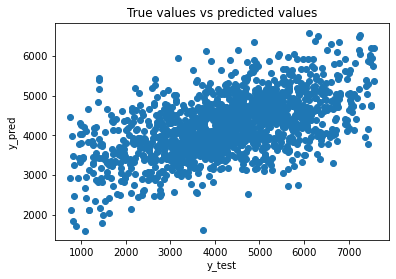

In [182]:
plt.scatter(y_test, y_pred)
plt.title('True values vs predicted values')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()